In [8]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import os.path 

In [5]:
import sys
d2_net_path = "/home/mikhail/research/d2-net/lib"
d2_net_path_lib = "/home/mikhail/research/d2-net"
if d2_net_path not in sys.path:
    sys.path.append(d2_net_path)
if d2_net_path_lib not in sys.path:
    sys.path.append(d2_net_path_lib)
from pyramid import process_multiscale
from model_test import D2Net
from utils import preprocess_image

# Make D2 model

In [6]:
MODEL_FILE = "/home/mikhail/research/d2-net/models/d2_ots.pth"
DATASET_PATH = "data/7scenes/fire"
ROOT_PATH = "/home/mikhail/research/unsup-3d-keypoints"

In [7]:
MODEL = D2Net(
    model_file=MODEL_FILE,
    use_relu=True,
    use_cuda=True
)

# Load image

In [20]:
IMAGE_PATH = "/home/mikhail/research/lie-pose-net/data/7scenes/fire/seq-01/frame-000001.color.png"

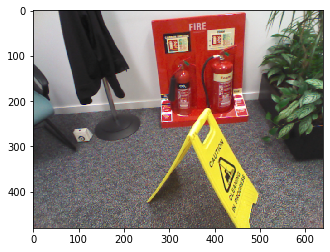

In [21]:
INPUT_IMAGE = np.asarray(Image.open(IMAGE_PATH))
plt.imshow(INPUT_IMAGE)

In [22]:
IMAGE_TENSOR = preprocess_image(INPUT_IMAGE, preprocessing="torch")[None]
IMAGE_TENSOR = torch.tensor(IMAGE_TENSOR).float().cuda()
IMAGE_TENSOR.size()

torch.Size([1, 3, 480, 640])

In [23]:
with torch.no_grad():
    keypoints, scores, descriptors = process_multiscale(IMAGE_TENSOR, MODEL, scales=[1])

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


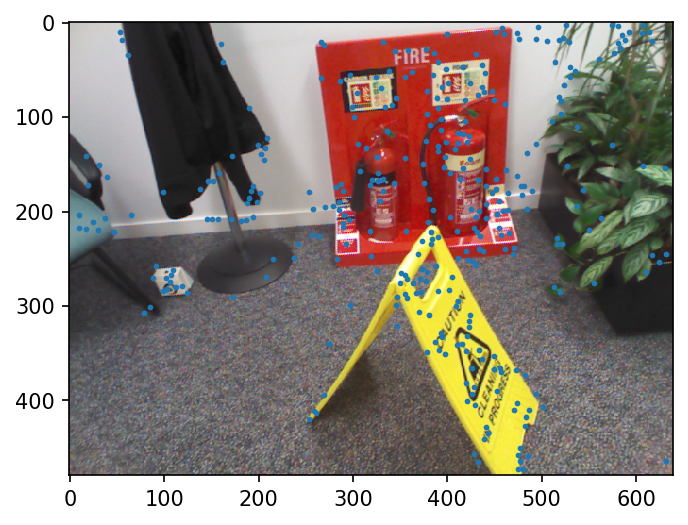

In [24]:
plt.figure(dpi=150)
plt.imshow(INPUT_IMAGE)
mask = scores > 15
plt.scatter(keypoints[mask, 1], keypoints[mask, 0], s=3)

## from sklearn.decomposition import PCA

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=3).fit(descriptors)
pca_descriptors = pca.transform(descriptors[mask])
len(pca_descriptors)

343

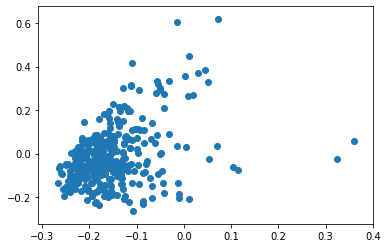

In [27]:
plt.scatter(pca_descriptors[:, 0], pca_descriptors[:, 1])

In [28]:
max_c = np.max(pca_descriptors)
min_c = np.min(pca_descriptors)
colors = np.clip((pca_descriptors - min_c) / (max_c - min_c), 0, 1)

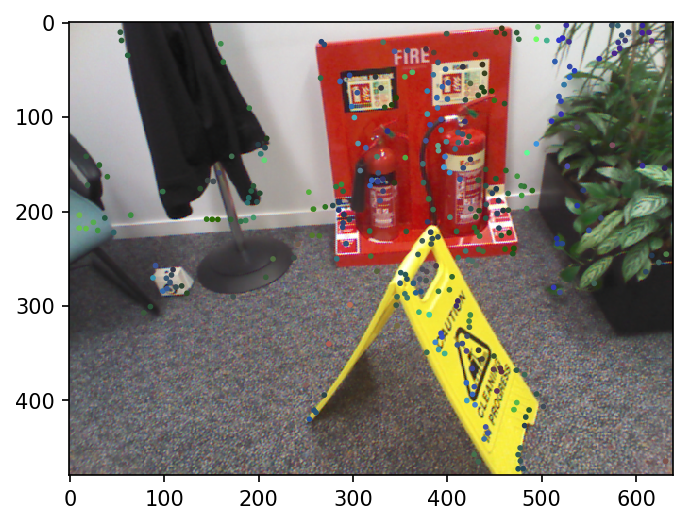

In [29]:
plt.figure(dpi=150)
plt.imshow(INPUT_IMAGE)
plt.scatter(keypoints[mask, 1], keypoints[mask, 0], s=3, c=colors)

In [30]:
def get_keypoints(model, image_path, min_score=None):
    image = np.asarray(Image.open(image_path))
    image_tensor = preprocess_image(image, preprocessing="torch")[None]
    image_tensor = torch.tensor(image_tensor).float().cuda()
    with torch.no_grad():
        keypoints, scores, descriptors = process_multiscale(image_tensor, model, scales=[1])
    if min_score is not None:
        mask = scores > min_score
        keypoints = keypoints[mask]
        descriptors = descriptors[mask]
    return keypoints.copy(), descriptors.copy()

# Matching

In [31]:
import cv2

In [32]:
from kapture_localization.matching.matching import MatchPairNnTorch

In [33]:
IMAGE_PATH1 = "/home/mikhail/research/lie-pose-net/data/7scenes/fire/seq-01/frame-000001.color.png"
IMAGE_PATH2 = "/home/mikhail/research/lie-pose-net/data/7scenes/fire/seq-01/frame-000030.color.png"
INPUT_IMAGE1 = np.asarray(Image.open(IMAGE_PATH1))
INPUT_IMAGE2 = np.asarray(Image.open(IMAGE_PATH2))

In [34]:
keypoints1, descriptors1 = get_keypoints(MODEL, IMAGE_PATH1, 15)
keypoints2, descriptors2 = get_keypoints(MODEL, IMAGE_PATH2, 15)

In [35]:
MATCHER = MatchPairNnTorch()

In [36]:
matches = MATCHER.match_descriptors(descriptors1, descriptors2)

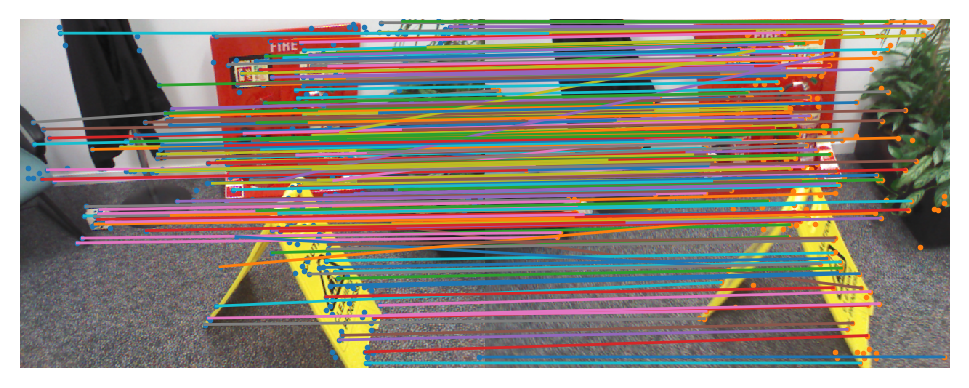

In [37]:
plt.figure(dpi=200)
output_image = np.concatenate([INPUT_IMAGE1, INPUT_IMAGE2], axis=1)

plt.imshow(output_image)
plt.scatter(keypoints1[:, 1], keypoints1[:, 0], s=1)
plt.scatter(keypoints2[:, 1] + 640, keypoints2[:, 0], s=1)
for match in matches:
    plt.plot([keypoints1[int(match[0]), 1], keypoints2[int(match[1]), 1] + 640], 
             [keypoints1[int(match[0]), 0], keypoints2[int(match[1]), 0]], linewidth=1)
plt.axis('off');